# Time 

## 1. duration

### i. monotonic clock vs non-monotonic clock
<blockquote>
    Monotonic clock: A clock that always moves forward — it never goes backward, even if the system time changes
</blockquote>

### ii. non-monotonic clock
- time.time() - float (seconds)
  - time.time_ns() - int (nanoseconds)
  - generated from utc timestamp
  - system clock:
    - Windows: call GetSystemTimePreciseAsFileTime()
    - Call clock_gettime(CLOCK_REALTIME) if available
    - Otherwise, call gettimeofday()
  - unreliable if system time changes like going back or jumping
    - e.g. manual clock change, NTP time sync, daylight saving adjustment

In [1]:
from datetime import datetime, timezone
import time

# test timestamp generation
start_time = time.time()
start_time_ns = time.time_ns()
time_now = datetime.now(timezone.utc)
timestamp = time_now.timestamp()

print(f"time.time:{start_time}")
print(f"time.time_ns:{start_time_ns}")
print(f"now-utc:{time_now}")
print(f"now-timestamp:{timestamp}")

# test duration
time.sleep(2)
end_time = time.time()
end_time_ns = time.time_ns()
elapsed_time = end_time - start_time
elapsed_time_ns = end_time_ns - start_time_ns
print(f"Elapsed time using time.time(): {elapsed_time:.6f} seconds")
print(f"Elapsed time using time.time_ns(): {elapsed_time_ns} nanoseconds")

time.time:1754604268.141836
time.time_ns:1754604268141883000
now-utc:2025-08-07 22:04:28.141950+00:00
now-timestamp:1754604268.14195
Elapsed time using time.time(): 2.005277 seconds
Elapsed time using time.time_ns(): 2005340000 nanoseconds


### iii. monotonic clock
- time.monotonic() - float (fractional seconds)
  - time.monotonic_ns() - int (nanoseconds)  
  - include time elapsed during sleep
  - the clock is not affected by system clock updates
  - monotonic clock:
    - Windows: call QueryPerformanceCounter() and QueryPerformanceFrequency().
    - macOS: call mach_absolute_time() and mach_timebase_info().
    - HP-UX: call gethrtime().
    - Call clock_gettime(CLOCK_HIGHRES) if available.
    - Otherwise, call clock_gettime(CLOCK_MONOTONIC).   
- time.perf_counter() - float (fractional seconds)
  - time.perf_counter_ns() - int (nanoseconds)
  - include time elapsed during sleep
  - the clock is not affected by system clock updates
  - clock: as same as monotonic for cpython
  - high-precision performance benchmarking
- time.thread_time() - float (fractional seconds)
  - time.thread_time_ns() - int (nanoseconds)
  - CPU time of the current thread
  - not include time elapsed during sleep
- time.process_time()  - float (fractional seconds)
  - time.process_time_ns() - int (nanoseconds)
  - CPU time of the current process
  - not include time elapsed during sleep


In [3]:
import time

# record starting time
start_monotonic = time.monotonic()
start_perf = time.perf_counter()
start_proc = time.process_time()
start_thread = time.thread_time()

# test duration
time.sleep(2)
end_monotonic = time.monotonic()
end_perf = time.perf_counter()
end_proc = time.process_time()
end_thread = time.thread_time()

elapsed_monotonic = end_monotonic - start_monotonic
elapsed_perf = end_perf  - start_perf
elapsed_proc = end_proc - start_proc
elapsed_thread = end_thread - start_thread
print(f"Elapsed time using time.monotonic(): {elapsed_monotonic:.6f} seconds")
print(f"Elapsed time using time.perf_counter(): {elapsed_perf:.6f} seconds")
print(f"Process Time: {elapsed_proc:.6f} s")
print(f"Thread Time : {elapsed_thread:.6f} s")


Elapsed time using time.monotonic(): 2.005801 seconds
Elapsed time using time.perf_counter(): 2.005873 seconds
Process Time: 0.004707 s
Thread Time : 0.001092 s


In [5]:
import threading
import time

def cpu_task(name):
    print(f"[{name}] Starting...")
    
    start_proc = time.process_time()
    start_thread = time.thread_time()

    # Simulate CPU work
    total = 0
    for i in range(10**7):
        total += i * i

    end_proc = time.process_time()
    end_thread = time.thread_time()
    time.sleep(2)
    sleep_proc = time.process_time()
    sleep_thread = time.thread_time()

    print(f"[{name}] CPU Task Done.")
    print(f"[{name}] Process Time: {end_proc - start_proc:.6f} s")
    print(f"[{name}] Thread Time : {end_thread - start_thread:.6f} s")
    print(f"[{name}] Process Time after sleep: {sleep_proc - end_proc:.6f} s")
    print(f"[{name}] Thread Time after sleep: {sleep_thread - end_thread:.6f} s")

# Create multiple threads
t1 = threading.Thread(target=cpu_task, args=("Thread-1",))
t2 = threading.Thread(target=cpu_task, args=("Thread-2",))

# Start threads
t1.start()
t2.start()

# Wait for them to finish
t1.join()
t2.join()

[Thread-1] Starting...
[Thread-2] Starting...
[Thread-1] CPU Task Done.
[Thread-1] Process Time: 1.543090 s
[Thread-1] Thread Time : 0.769105 s
[Thread-1] Process Time after sleep: 0.025332 s
[Thread-1] Thread Time after sleep: 0.000067 s
[Thread-2] CPU Task Done.
[Thread-2] Process Time: 1.561734 s
[Thread-2] Thread Time : 0.792808 s
[Thread-2] Process Time after sleep: 0.001581 s
[Thread-2] Thread Time after sleep: 0.000045 s


### iiii. time backwards trial
- freezegun
  - freeze_time
    - set time point
    - default for utc
    - wrong for time.monotonic and time.perf_counter
- time-machine
  - time_machine.travel
    - set time point
    - default for utc
    - wrong for time.monotonic 

In [ ]:
pip install freezegun

In [8]:
from freezegun import freeze_time
from datetime import datetime, timedelta, timezone
import time


print("Test started")

# Record times at the beginning
start_time = time.time()
start_monotonic = time.monotonic()
start_perf = time.perf_counter()
start_proc = time.process_time()
start_thread = time.thread_time()

# Shift time 10 seconds into the past
time_now = datetime.now(timezone.utc)
ten_seconds_ago = time_now - timedelta(seconds=10)

print(f"before freezing time:{time_now}")
# parameter formats
# -freeze_time("2025-08-07 12:00:00")
# -freeze_time(datetime(2025, 8, 7)) 
# Simulate a 10-second backward clock change
# default using utc time   
# only affect time inside with
with freeze_time(ten_seconds_ago):
    # Sleep to simulate work
    time.sleep(2)
    end_time = time.time()
    end_monotonic = time.monotonic()
    end_perf = time.perf_counter()
    end_proc = time.process_time()
    end_thread = time.thread_time()

    time_now = datetime.now(timezone.utc)
    print(f"freezing time:{time_now}")

time_now = datetime.now(timezone.utc)
print(f"after freezing time:{time_now}")

# Compare durations
elapsed_time = end_time - start_time
elapsed_monotonic = end_monotonic - start_monotonic
elapsed_perf = end_perf  - start_perf
elapsed_proc = end_proc - start_proc
elapsed_thread = end_thread - start_thread
print(f"Elapsed time using time.time(): {elapsed_time:.6f} seconds")
print(f"Elapsed time using time.monotonic(): {elapsed_monotonic:.6f} seconds")
print(f"Elapsed time using time.perf_counter(): {elapsed_perf:.6f} seconds")
print(f"Process Time: {elapsed_proc:.6f} s")
print(f"Thread Time : {elapsed_thread:.6f} s")


Test started
before freezing time:2025-08-07 22:05:12.658092+00:00
freezing time:2025-08-07 22:05:02.658092+00:00
after freezing time:2025-08-07 22:05:14.775566+00:00
Elapsed time using time.time(): -9.999798 seconds
Elapsed time using time.monotonic(): 1754581759.670318 seconds
Elapsed time using time.perf_counter(): 1754581759.670282 seconds
Process Time: 0.098854 s
Thread Time : 0.094658 s


In [ ]:
pip install time_machine

In [16]:
import time_machine
from datetime import datetime, timezone, timedelta

# Record times at the beginning
start_time = time.time()
start_mono = time.monotonic()
start_perf = time.perf_counter()

time_now = datetime.now(timezone.utc)
ten_seconds_ago = time_now - timedelta(seconds=10)
print(f"before freezing time:{time_now}")

# parameters:
# - moment: datetime, unix timestamp, str
# - tick: False = freeze
with time_machine.travel(ten_seconds_ago):

    time.sleep(2)
    end_time = time.time()
    end_mono = time.monotonic()
    end_perf = time.perf_counter()

    time_now = datetime.now(timezone.utc)
    print(f"freezing time:{time_now}")

time_now = datetime.now(timezone.utc)
print(f"after freezing time:{time_now}")

# Compare durations
elapsed_time = end_time - start_time
elapsed_mono = end_mono - start_mono
elapsed_perf = end_perf - start_perf
print(f"Elapsed time using time.time(): {elapsed_time:.6f} seconds")
print(f"Elapsed time using time.monotonic(): {elapsed_mono:.6f} seconds")
print(f"Elapsed time using time.perf_counter(): {elapsed_perf:.6f} seconds")


before freezing time:2025-08-07 22:15:21.811609+00:00
freezing time:2025-08-07 22:15:13.813611+00:00
after freezing time:2025-08-07 22:15:23.815268+00:00
Elapsed time using time.time(): -7.997904 seconds
Elapsed time using time.monotonic(): -7.997931 seconds
Elapsed time using time.perf_counter(): 2.003150 seconds


## 2. precision
time.time() vs time.monotonic() vs time.perf_counter()

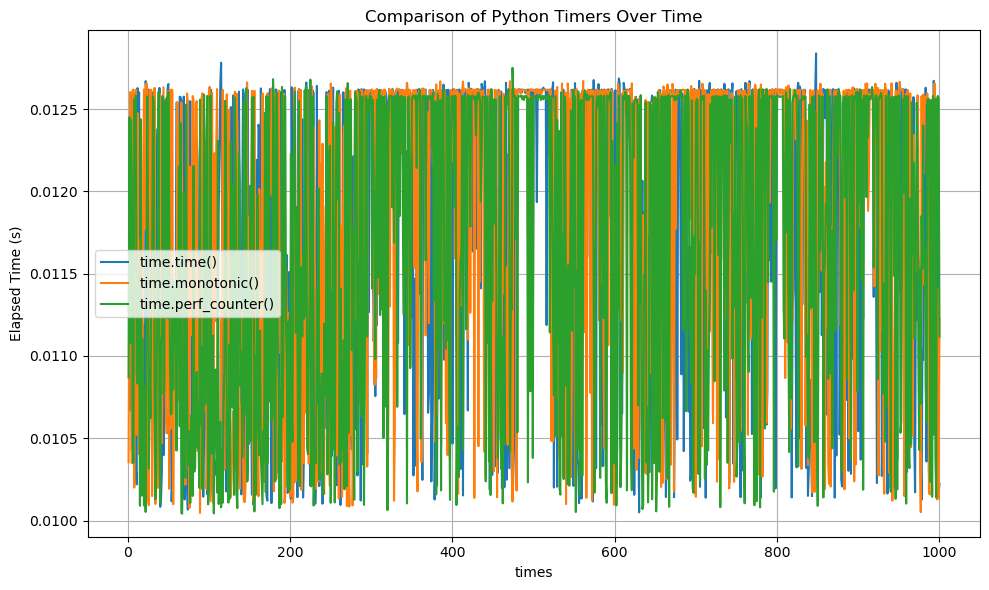


time.monotonic()
----------------
Min:       0.010046005249
Max:       0.012670993805
Mean:      0.011794514894
Std dev:   0.000924748558
sum:       11.794514894485
Max decimal digits observed: 18

time.perf_counter()
-------------------
Min:       0.010041617999
Max:       0.012751271999
Mean:      0.011675651818
Std dev:   0.000941111343
sum:       11.675651817986
Max decimal digits observed: 18

time.time()
-----------
Min:       0.010050058365
Max:       0.012839078903
Mean:      0.011744512558
Std dev:   0.000930858822
sum:       11.744512557983
Max decimal digits observed: 18


In [30]:
import time
import matplotlib.pyplot as plt
import numpy as np
import statistics

iterations = 1_000
sleep_duration = 0.01
mono_times = np.zeros(iterations)
perf_times = np.zeros(iterations)
times = np.zeros(iterations)
x_values = np.linspace(1,iterations,iterations)

for i in range(iterations):
    # time.time()
    start_time = time.time()
    time.sleep(sleep_duration)
    end_time = time.time()
    duration_time = end_time - start_time
    times[i] = duration_time 
    
    # time.monotonic()
    start_mono = time.monotonic()
    time.sleep(sleep_duration)
    end_mono = time.monotonic()
    duration_mono = end_mono - start_mono
    mono_times[i] = duration_mono 
    
    
    # time.perf_counter()
    start_perf = time.perf_counter()
    time.sleep(sleep_duration)
    end_perf = time.perf_counter()
    duration_perf = end_perf - start_perf
    perf_times[i] = duration_perf

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, times, label='time.time()')
plt.plot(x_values, mono_times, label='time.monotonic()')
plt.plot(x_values, perf_times, label='time.perf_counter()')
plt.xlabel('times')
plt.ylabel('Elapsed Time (s)')
plt.title('Comparison of Python Timers Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Stats
def print_stats(name, data):
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Min:       {min(data):.12f}")
    print(f"Max:       {max(data):.12f}")
    print(f"Mean:      {statistics.mean(data):.12f}")
    print(f"Std dev:   {statistics.stdev(data):.12f}")
    print(f"sum:       {sum(data):.12f}")
    # Significant digits: average number of decimal places that change
    sig_digits = max(len(str(x).split('.')[-1].rstrip('0')) for x in data)
    print(f"Max decimal digits observed: {sig_digits}")

print_stats("time.monotonic()", mono_times)
print_stats("time.perf_counter()", perf_times)
print_stats("time.time()", times)
